In [ ]:
import re
import math
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spacy
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, Input, TimeDistributed

In [ ]:
summary=pd.read_csv('/content/drive/My Drive/nlp/data/summary_final.csv')
raw = pd.read_csv('/content/drive/My Drive/nlp/data/raw.csv')
raw

,Unnamed: 0,headlines,text
0,0,79-yr-old fined â¹4.7L for breaching self-iso...,A 79-year-old pensioner in the UK has been fin...
1,1,N Korean leader Kim wishes Trump quick recover...,North Korean leader Kim Jong-un has wished US ...
2,2,Target would be to cover around 25cr people by...,"Speaking about the coronavirus vaccine plan, H..."
3,3,"90 sixes, 1,303 runs scored in 3 IPL 2020 matc...",In the three IPL 2020 matches that took place ...
4,4,Afghanistan cricketer Najeebullah in ICU after...,Afghanistan's 29-year-old opener Najeebullah T...
...,...,...,...
9461,11248,China punishes Weibo for 'interfering with onl...,China's internet regulator has punished microb...
9462,11249,Apple's Siri begins answering 'Do black lives ...,In response to 'Do black lives matter?' Apple'...
9463,11250,Hyperloop could substitute short-haul flights ...,A study has predicted hyperloop can replace a ...
9464,11252,Questions on China shouldn't be asked on Twitt...,Union Minister Ravi Shankar Prasad said Congre...


In [ ]:
summary

,Unnamed: 0,headlines,text,date,author,read_more,ctext
0,0,79-yr-old fined â¹4.7L for breaching self-iso...,A 79-year-old pensioner in the UK has been fin...,"04 Oct 2020,Sunday",Pragya Swastik,https://www.timesnownews.com/amp/the-buzz/arti...,A pensioner who went out for a pint when he sh...
1,1,N Korean leader Kim wishes Trump quick recover...,North Korean leader Kim Jong-un has wished US ...,"04 Oct 2020,Sunday",Shailesh,https://zeenews.india.com/world/north-koreas-k...,Kim offered his sympathy and `warm greetings` ...
2,2,Target would be to cover around 25cr people by...,"Speaking about the coronavirus vaccine plan, H...","04 Oct 2020,Sunday",Arshiya Chopra,https://www.deccanherald.com/amp/national/arou...,Addressing the nation on some key questions re...
3,3,"90 sixes, 1,303 runs scored in 3 IPL 2020 matc...",In the three IPL 2020 matches that took place ...,"04 Oct 2020,Sunday",Anmol Sharma,https://www.iplt20.com/match/2020/16?tab=score...,A breakdown of the questions you voted on will...
4,4,Afghanistan cricketer Najeebullah in ICU after...,Afghanistan's 29-year-old opener Najeebullah T...,"04 Oct 2020,Sunday",Anmol Sharma,https://www.india.com/sports/afghanistan-crick...,Afghanistan opener Najeebullah Tarakai is in a...
...,...,...,...,...,...,...,...
9461,11248,China punishes Weibo for 'interfering with onl...,China's internet regulator has punished microb...,"10 Jun 2020,Wednesday",Aishwarya,https://in.reuters.com/article/china-censorshi...,HONG KONG (Reuters) - China’s internet regulat...
9462,11249,Apple's Siri begins answering 'Do black lives ...,In response to 'Do black lives matter?' Apple'...,"10 Jun 2020,Wednesday",Aishwarya,https://tech.hindustantimes.com/tech/news/appl...,Apple has updated Siri to respond differently ...
9463,11250,Hyperloop could substitute short-haul flights ...,A study has predicted hyperloop can replace a ...,"10 Jun 2020,Wednesday",Aishwarya,https://in.reuters.com/article/aviation-nether...,LONDON (Reuters) - Passenger-packed pods speed...
9464,11252,Questions on China shouldn't be asked on Twitt...,Union Minister Ravi Shankar Prasad said Congre...,"10 Jun 2020,Wednesday",Kiran Khatri,https://www.thequint.com/news/ravi-shankar-pra...,"“RG should know that on international matters,..."


In [ ]:
raw

,Unnamed: 0,headlines,text
0,0,79-yr-old fined â¹4.7L for breaching self-iso...,A 79-year-old pensioner in the UK has been fin...
1,1,N Korean leader Kim wishes Trump quick recover...,North Korean leader Kim Jong-un has wished US ...
2,2,Target would be to cover around 25cr people by...,"Speaking about the coronavirus vaccine plan, H..."
3,3,"90 sixes, 1,303 runs scored in 3 IPL 2020 matc...",In the three IPL 2020 matches that took place ...
4,4,Afghanistan cricketer Najeebullah in ICU after...,Afghanistan's 29-year-old opener Najeebullah T...
...,...,...,...
9461,11248,China punishes Weibo for 'interfering with onl...,China's internet regulator has punished microb...
9462,11249,Apple's Siri begins answering 'Do black lives ...,In response to 'Do black lives matter?' Apple'...
9463,11250,Hyperloop could substitute short-haul flights ...,A study has predicted hyperloop can replace a ...
9464,11252,Questions on China shouldn't be asked on Twitt...,Union Minister Ravi Shankar Prasad said Congre...


In [ ]:
pre1 =  raw.iloc[:,0:3].copy()
pre1['head + text'] = pre1['headlines'].str.cat(pre1['text'], sep =" ") 

pre2 = summary.iloc[:,0:7].copy()
pre2['head + text'] = pre2['author'].str.cat(pre2['date'].str.cat(pre2['headlines'].str.cat(pre2['read_more'].str.cat(pre2['text'].str.cat(pre2['ctext'], sep = " "), sep =" "),sep= " "), sep = " "),sep= " ")

In [ ]:
pre1.head()

,Unnamed: 0,headlines,text,head + text
0,0,79-yr-old fined â¹4.7L for breaching self-iso...,A 79-year-old pensioner in the UK has been fin...,79-yr-old fined â¹4.7L for breaching self-iso...
1,1,N Korean leader Kim wishes Trump quick recover...,North Korean leader Kim Jong-un has wished US ...,N Korean leader Kim wishes Trump quick recover...
2,2,Target would be to cover around 25cr people by...,"Speaking about the coronavirus vaccine plan, H...",Target would be to cover around 25cr people by...
3,3,"90 sixes, 1,303 runs scored in 3 IPL 2020 matc...",In the three IPL 2020 matches that took place ...,"90 sixes, 1,303 runs scored in 3 IPL 2020 matc..."
4,4,Afghanistan cricketer Najeebullah in ICU after...,Afghanistan's 29-year-old opener Najeebullah T...,Afghanistan cricketer Najeebullah in ICU after...


In [ ]:
pre2.head(2)

,Unnamed: 0,headlines,text,date,author,read_more,ctext,head + text
0,0,79-yr-old fined â¹4.7L for breaching self-iso...,A 79-year-old pensioner in the UK has been fin...,"04 Oct 2020,Sunday",Pragya Swastik,https://www.timesnownews.com/amp/the-buzz/arti...,A pensioner who went out for a pint when he sh...,"Pragya Swastik 04 Oct 2020,Sunday 79-yr-old fi..."
1,1,N Korean leader Kim wishes Trump quick recover...,North Korean leader Kim Jong-un has wished US ...,"04 Oct 2020,Sunday",Shailesh,https://zeenews.india.com/world/north-koreas-k...,Kim offered his sympathy and `warm greetings` ...,"Shailesh 04 Oct 2020,Sunday N Korean leader Ki..."


In [ ]:
pre = pd.DataFrame()
pre['head + text'] = pd.concat([pre1['head + text'], pre2['head + text']], ignore_index=True)

In [ ]:
pre.head()

,head + text
0,79-yr-old fined â¹4.7L for breaching self-iso...
1,N Korean leader Kim wishes Trump quick recover...
2,Target would be to cover around 25cr people by...
3,"90 sixes, 1,303 runs scored in 3 IPL 2020 matc..."
4,Afghanistan cricketer Najeebullah in ICU after...


##  Create a W2V model more creating word vectors

In [ ]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)


In [ ]:
#DATA CLEANSING
#Scope for Improvement by loading lg model

nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [ ]:
#Removes non-alphabetic characters:
def text_strip():
    for row in pre['head + text']:
        
        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM
        
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)
        
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        
        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them
        

        
        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces
        
        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        
        
        yield row


brief_cleaning = text_strip()

In [ ]:
#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:

t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 2.77 mins


In [ ]:
txt[0]

'79-yr - old fine â\x82¹4.7l breach self - isolation beer uk 79-year - old pensioner uk fine â£5 000 â\x82¹4.7 lakh breach 14-day self - isolation period arrive guernsey uk mainland man drive pub pint beer breach self - isolation police confront claim technically isolating pub .'

In [ ]:
pre_clean = pd.DataFrame({'cleaned head + text': txt})
pre_clean = pre_clean.dropna().drop_duplicates()
pre_clean.shape


INFO - 09:50:17: NumExpr defaulting to 2 threads.


(18932, 1)

In [ ]:
# Bigrams:
# We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences. https://radimrehurek.com/gensim/models/phrases.html

# The main reason we do this is to catch words like "t_mobile" or "nbc_universal" !


from gensim.models.phrases import Phrases, Phraser

#Split the words by space
sent = [row.split() for row in pre_clean['cleaned head + text']]

#They should appear in the joint form minimum 50 times
#Phrases() takes a list of list of words as input:

phrases = Phrases(sent, min_count=50, progress_per=10000)


INFO - 09:50:18: 'pattern' package not found; tag filters are not available for English
INFO - 09:50:18: collecting all words and their counts
INFO - 09:50:18: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 09:50:19: PROGRESS: at sentence #10000, processed 556960 words and 346577 word types
INFO - 09:50:22: collected 1240572 word types from a corpus of 2999752 words (unigram + bigrams) and 18932 sentences
INFO - 09:50:22: using 1240572 counts as vocab in Phrases<0 vocab, min_count=50, threshold=10.0, max_vocab_size=40000000>


In [ ]:
#The goal of Phraser() is to cut down memory consumption of Phrases(), 
#by discarding model state not strictly needed for the bigram detection task:
bigram = Phraser(phrases)

INFO - 09:50:22: source_vocab length 1240572
INFO - 09:50:33: Phraser built with 1619 phrasegrams


In [ ]:
sentences  = bigram[sent]

In [ ]:
#Sentences is basically a list of list fed to w2v for training
sentences[0]

['79-yr',
 '-_old',
 'fine',
 'â\x82¹4.7l',
 'breach',
 'self_-',
 'isolation',
 'beer',
 'uk',
 '79-year',
 '-_old',
 'pensioner',
 'uk',
 'fine',
 'â£5',
 '000',
 'â\x82¹4.7',
 'lakh',
 'breach',
 '14-day',
 'self_-',
 'isolation',
 'period',
 'arrive',
 'guernsey',
 'uk',
 'mainland',
 'man',
 'drive',
 'pub',
 'pint',
 'beer',
 'breach',
 'self_-',
 'isolation',
 'police',
 'confront',
 'claim',
 'technically',
 'isolating',
 'pub',
 '.']

In [ ]:
#Sort the words by thier frequency and print them

word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
print(len(word_freq))

print(sorted(word_freq, key=word_freq.get, reverse=True)[:10])

71655
['say', '-', '"', '.', 'india', 'people', 'add', 'report', 'year', 'state']


## Generating a W2V model

In [ ]:
#---------------------Training the W2V Model-----------------------#

import multiprocessing
from gensim.models import Word2Vec

cores = multiprocessing.cpu_count() # Count the number of cores in a computer

#initialize w2v parameters
w2v_model = Word2Vec(min_count=30,
                     window=2,
                     size=200,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [ ]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 09:50:40: collecting all words and their counts
INFO - 09:50:40: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 09:50:41: PROGRESS: at sentence #10000, processed 515575 words, keeping 31163 word types
INFO - 09:50:46: collected 71655 word types from a corpus of 2727503 raw words and 18932 sentences
INFO - 09:50:46: Loading a fresh vocabulary
INFO - 09:50:46: effective_min_count=30 retains 9451 unique words (13% of original 71655, drops 62204)
INFO - 09:50:46: effective_min_count=30 leaves 2457241 word corpus (90% of original 2727503, drops 270262)
INFO - 09:50:46: deleting the raw counts dictionary of 71655 items
INFO - 09:50:46: sample=6e-05 downsamples 1308 most-common words
INFO - 09:50:46: downsampling leaves estimated 1533006 word corpus (62.4% of prior 2457241)
INFO - 09:50:46: estimated required memory for 9451 words and 200 dimensions: 19847100 bytes
INFO - 09:50:46: resetting layer weights


Time to build vocab: 0.14 mins


In [ ]:
#Now actually train model on the list of list of words
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

#Takes 10 mins for 79mil words.
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 09:50:48: training model with 1 workers on 9451 vocabulary and 200 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 09:50:49: EPOCH 1 - PROGRESS: at 24.52% examples, 102361 words/s, in_qsize 1, out_qsize 0
INFO - 09:50:50: EPOCH 1 - PROGRESS: at 50.07% examples, 106613 words/s, in_qsize 1, out_qsize 0
INFO - 09:50:51: EPOCH 1 - PROGRESS: at 54.65% examples, 108781 words/s, in_qsize 1, out_qsize 0
INFO - 09:50:52: EPOCH 1 - PROGRESS: at 59.09% examples, 109170 words/s, in_qsize 1, out_qsize 0
INFO - 09:50:53: EPOCH 1 - PROGRESS: at 63.25% examples, 108828 words/s, in_qsize 1, out_qsize 0
INFO - 09:50:54: EPOCH 1 - PROGRESS: at 67.64% examples, 108854 words/s, in_qsize 1, out_qsize 0
INFO - 09:50:55: EPOCH 1 - PROGRESS: at 72.08% examples, 108941 words/s, in_qsize 1, out_qsize 0
INFO - 09:50:56: EPOCH 1 - PROGRESS: at 76.45% examples, 108981 words/s, in_qsize 1, out_qsize 0
INFO - 09:50:57: EPOCH 1 - PROGRESS: at 80.82% examples, 109261 words/s, in_qsize 1, out_q

Time to train the model: 6.87 mins


In [ ]:
#This makes the model memory-efficient
w2v_model.init_sims(replace=True)

INFO - 09:57:40: precomputing L2-norms of word weight vectors


In [ ]:
w2v_model.save(fname_or_handle = "w2v_text_summ_200d_09162019")

INFO - 09:57:40: saving Word2Vec object under w2v_text_summ_200d_09162019, separately None
INFO - 09:57:40: not storing attribute vectors_norm
INFO - 09:57:40: not storing attribute cum_table
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
INFO - 09:57:40: saved w2v_text_summ_200d_09162019


## Data Viz

In [ ]:
#-------------------------DATA VISUALIZATION--------------------------#
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import gensim
from gensim.models import Word2Vec
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
#LOAD A W2V Model
MODEL_NAME = 'w2v_text_summ_200d_09162019'
EMAIL_W2V =  MODEL_NAME
email_model =  gensim.models.Word2Vec.load(EMAIL_W2V)

INFO - 09:57:40: loading Word2Vec object from w2v_text_summ_200d_09162019
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
INFO - 09:57:41: loading wv recursively from w2v_text_summ_200d_09162019.wv.* with mmap=None
INFO - 09:57:41: setting ignored attribute vectors_norm to None
INFO - 09:57:41: loading vocabulary recursively from w2v_text_summ_200d_09162019.vocabulary.* with mmap=None
INFO - 09:57:41: loading trainables recursively from w2v_text_summ_200d_09162019.trainables.* with mmap=None
INFO - 09:57:41: setting ignored attribute cum_table to None
INFO - 09:57:41: loaded w2v_text_summ_200d_09162019


In [ ]:
import time

def tsne_plot(model):
    start =  time.time()
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    end = time.time()
    print('{} seconds taken to index the w2v model'.format(end-start))


    
    return x,y,labels


In [ ]:
def matplot_plot(x,y,labels):
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [ ]:
#--------------BOKEH PLOT------------------#
from bokeh.plotting import *
from bokeh.models import *
from bokeh.layouts import *
from bokeh.io import *
from bokeh.embed import *
from bokeh.resources import *
import pandas as pd
output_notebook() 
def bokehplotw2v(x,y,labels,MODEL_NAME):
    df = pd.DataFrame(list(zip(x, y, labels)),columns =['X', 'Y', 'LABELS']) 
    source = ColumnDataSource(data=df)
    labeled_w2v_plot = figure(plot_width=1500,title="Labelled W2V graph")
    labels = LabelSet(x='X', y='Y', text='LABELS', level='glyph',source=source,x_offset=5, y_offset=5)
    labeled_w2v_plot.circle(x, y)   
    labeled_w2v_plot.add_layout(labels)
    simple_w2v_plot = figure(plot_width=labeled_w2v_plot.plot_width, x_range=labeled_w2v_plot.x_range, y_range=labeled_w2v_plot.y_range,title="Simple W2V graph")
    simple_w2v_plot.circle(x, y)
    plot = column(labeled_w2v_plot, simple_w2v_plot)
    html_name = MODEL_NAME + '.html'
    output_file(html_name,mode='inline')
    show(plot)
    save(plot)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def tsnescatterplot(model, word, list_names,VECTOR_DIMENTION):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, VECTOR_DIMENTION), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=12).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))


In [ ]:
x,y,labels = tsne_plot(email_model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


220.67229533195496 seconds taken to index the w2v model


In [ ]:
#Plot w2v in Bokeh
bokehplotw2v(x,y,labels,MODEL_NAME)     

INFO - 10:01:22: Session output file 'w2v_text_summ_200d_09162019.html' already exists, will be overwritten.


INFO - 10:01:24: precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


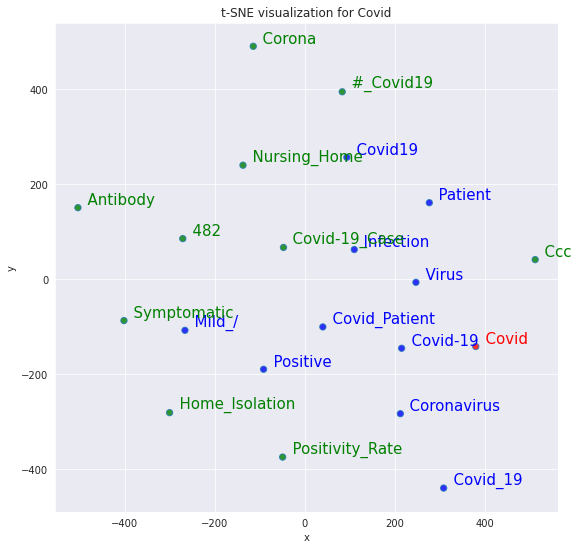

In [ ]:
WORD ='covid'
VECTOR_DIMENTION=200
list_names=[t[0] for t in email_model.wv.most_similar(positive=[WORD.lower()], topn=20)][10:]
tsnescatterplot(email_model, WORD.lower(),list_names,VECTOR_DIMENTION)

# SEQ2SEQ

In [ ]:
summary=pd.read_csv('/content/drive/My Drive/nlp/data/summary_final.csv')
raw = pd.read_csv('/content/drive/My Drive/nlp/data/raw.csv')

In [ ]:
pre1 =  raw.iloc[:,0:3].copy()
# pre1['head + text'] = pre1['headlines'].str.cat(pre1['text'], sep =" ") 
pre2 = summary.iloc[:,0:7].copy()
pre2['text'] = pre2['author'].str.cat(pre2['date'].str.cat(pre2['read_more'].str.cat(pre2['text'].str.cat(pre2['ctext'], sep = " "), sep =" "),sep= " "), sep = " ")

In [ ]:
pre = pd.DataFrame()
pre['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
pre['summary'] = pd.concat([pre1['headlines'],pre2['headlines']],ignore_index = True)

In [ ]:
pre.head()

,text,summary
0,A 79-year-old pensioner in the UK has been fin...,79-yr-old fined â¹4.7L for breaching self-iso...
1,North Korean leader Kim Jong-un has wished US ...,N Korean leader Kim wishes Trump quick recover...
2,"Speaking about the coronavirus vaccine plan, H...",Target would be to cover around 25cr people by...
3,In the three IPL 2020 matches that took place ...,"90 sixes, 1,303 runs scored in 3 IPL 2020 matc..."
4,Afghanistan's 29-year-old opener Najeebullah T...,Afghanistan cricketer Najeebullah in ICU after...


In [ ]:
pre['text'][:10]

0    A 79-year-old pensioner in the UK has been fin...
1    North Korean leader Kim Jong-un has wished US ...
2    Speaking about the coronavirus vaccine plan, H...
3    In the three IPL 2020 matches that took place ...
4    Afghanistan's 29-year-old opener Najeebullah T...
5    RCB captain Virat Kohli, who scored an unbeate...
6    NITI Aayog CEO Amitabh Kant on Saturday said t...
7    National level shooter Shreyasi Singh will on ...
8    As many as 141 prisoners were released from va...
9    A minor girl was allegedly raped in Madhya Pra...
Name: text, dtype: object

In [ ]:
import re

#Removes non-alphabetic characters:
def text_strip(column):
    for row in column:
        
        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM
        
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)
        
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        
        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them
        

        
        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces
        
        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        
        
        yield row

In [ ]:
brief_cleaning1 = text_strip(pre['text'])
brief_cleaning2 = text_strip(pre['summary'])

In [ ]:
from time import time
import spacy
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:
#If data loss seems to be happening(i.e len(text) = 50 instead of 75 etc etc) in this cell , decrease the batch_size parameter 

t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
text = [str(doc) for doc in nlp.pipe(brief_cleaning1, batch_size=5000, n_threads=-1)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))


Time to clean up everything: 2.51 mins


In [ ]:

t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(brief_cleaning2, batch_size=5000, n_threads=-1)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.15 mins


In [ ]:
text[1]

'north korean leader kim jong-un has wished us president donald trump and his wife melania trump quick recovery from coronavirus state media said he kim hoped they will surely overcome it he sent warm greetings to them it added reportedly it the first time that kim has sent well wishes to world leader who tested positive for coronavirus.'

In [ ]:
summary[1]

'_START_ n korean leader kim wishes trump quick recovery from covid-19 _END_'

In [ ]:
pre['cleaned_text'] = pd.Series(text)
pre['cleaned_summary'] = pd.Series(summary)

In [ ]:
text_count = []
summary_count = []

In [ ]:
for sent in pre['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in pre['cleaned_summary']:
    summary_count.append(len(sent.split()))

In [ ]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

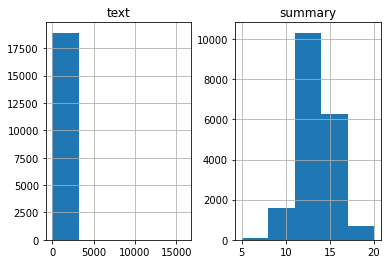

In [ ]:
import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [ ]:
#Check how much % of summary have 0-15 words
cnt=0
for i in pre['cleaned_summary']:
    if(len(i.split())<=15):
        cnt=cnt+1
print(cnt/len(pre['cleaned_summary']))

0.9083034016480034


In [ ]:
#Check how much % of text have 0-70 words
cnt=0
for i in pre['cleaned_text']:
    if(len(i.split())<=100):
        cnt=cnt+1
print(cnt/len(pre['cleaned_text']))

0.5415698288611874


In [ ]:
#Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len=100
max_summary_len=15
cleaned_text =np.array(pre['cleaned_text'])
cleaned_summary=np.array(pre['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})


In [ ]:
post_pre.head()

,text,summary
0,a 79-year-old pensioner in the uk has been fin...,_START_ 79-yr-old fined â¹4.7l for breaching ...
1,north korean leader kim jong-un has wished us ...,_START_ n korean leader kim wishes trump quick...
2,in the three ipl 2020 matches that took place ...,_START_ 90 sixes 303 runs scored in ipl 2020 m...
3,afghanistan 29-year-old opener najeebullah tar...,_START_ afghanistan cricketer najeebullah in i...
4,niti aayog ceo amitabh kant on saturday said t...,_START_ india can become ai laboratory of the ...


In [ ]:
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'start '+ x + ' end')

In [ ]:
post_pre.head()

,text,summary
0,a 79-year-old pensioner in the uk has been fin...,start _START_ 79-yr-old fined â¹4.7l for brea...
1,north korean leader kim jong-un has wished us ...,start _START_ n korean leader kim wishes trump...
2,in the three ipl 2020 matches that took place ...,start _START_ 90 sixes 303 runs scored in ipl ...
3,afghanistan 29-year-old opener najeebullah tar...,start _START_ afghanistan cricketer najeebulla...
4,niti aayog ceo amitabh kant on saturday said t...,start _START_ india can become ai laboratory o...


## Model Building

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)

In [ ]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 63.907520515606855
Total Coverage of rare words: 5.290570679547772


In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 9633


In [ ]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)


% of rare words in vocabulary: 79.23967459324155
Total Coverage of rare words: 14.819008158283548


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 2655


In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)


In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Size of vocabulary from the w2v model = 9633
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     1926600     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 300), ( 601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
66/66 [==============================] - 70s 1s/step - loss: 4.8811 - val_loss: 4.3323
Epoch 2/50
66/66 [==============================] - 69s 1s/step - loss: 4.3603 - val_loss: 4.2013
Epoch 3/50
66/66 [==============================] - 69s 1s/step - loss: 4.2426 - val_loss: 4.1278
Epoch 4/50
66/66 [==============================] - 69s 1s/step - loss: 4.1549 - val_loss: 4.0536
Epoch 5/50
66/66 [==============================] - 69s 1s/step - loss: 4.0774 - val_loss: 4.0146
Epoch 6/50
66/66 [==============================] - 69s 1s/step - loss: 4.0031 - val_loss: 3.9559
Epoch 7/50
66/66 [==============================] - 69s 1s/step - loss: 3.9303 - val_loss: 3.8913
Epoch 8/50
66/66 [==============================] - 69s 1s/step - loss: 3.9075 - val_loss: 3.8809
Epoch 9/50
66/66 [==============================] - 69s 1s/step - loss: 3.7983 - val_loss: 3.8163
Epoch 10/50
66/66 [==============================] - 69s 1s/step - loss: 3.7284 - val_loss: 3.7634
Epoch 11/50
66/66 [

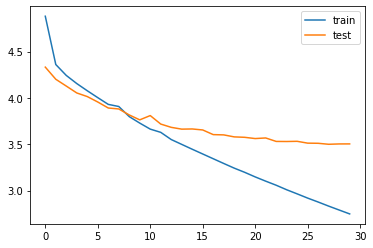

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(1,100):
    print("Review:",seq2text(x_tr[i]))
    print("Summary:",seq2summary(y_tr[i]))
    print("\n")

Review: 06 sep 2020 sunday police in punjab ludhiana have arrested local actor cum theatre artiste singh after video went viral in which he can be seen dressed as policeman in the video the man can also be seen drinking liquor and saying that alcohol is the treatment for coronavirus he has been arrested for spreading rumours and police uniform police said arshiya chopra held 0 
Summary: actor says alcohol covid 19 while posing as policeman 


Review: anmol sharma 04 aug 2020 tuesday www icc cricket com utm campaign fullarticle utm medium referral utm source inshorts england captain eoin morgan has set the record for hitting most sixes in international cricket as captain the 33 year old achieved the feat by taking his tally of sixes as captain in international cricket to 212 after slamming his first six in the third odi against ireland today morgan overtook ms dhoni who slammed sixes as captain in 330 innings sorry there are currently no videos available 
Summary: morgan most sixes as c